In [1]:
import gym
import os
from stable_baselines.results_plotter import load_results
from seagul.plot import smooth_bounded_curve
import matplotlib.pyplot as plt
import numpy as np
import torch
import pybullet_envs
from stable_baselines import TD3 as ALGO
import time
import seagul.envs
import pybullet as p
import json
import pybulletgym
from seagul.envs.wrappers import PyBulletPhysicsWrapper

#env_name = "Walker2d-v2"
#env_name = "Walker2DBulletEnv-v0"
#env_name = "pbmj_walker2dfc-v0"
env_name = "Walker2DMuJoCoEnv-v0"

def do_rollout_stable(init_point=None, render=False, video=False):
    #env = gym.make(env_name, render=render, **config)
    env = PyBulletPhysicsWrapper(gym.make(env_name, render=render), **config)
    model.observation_space = env.observation_space
    obs=env.reset()
    #td3_model = TD3.load(script_path + "../rl-baselines-zoo/baseline_log2/td3/su_acrobot_cdc-v0_2/su_acrobot_cdc-v0.zip")

    obs = torch.as_tensor(obs, dtype=torch.float32)

    acts_list = []
    obs1_list = []
    rews_list = []
    img_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    while not done:
        acts = model.predict(obs)[0]
        obs, rew, done, out = env.step(acts)
  
        if render:
            time.sleep(.005)
            env.unwrapped.camera_adjust()
        if video:
            img_list.append(env.render(mode='rgb_array'))
            env.unwrapped.camera_adjust()
            
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)
    p.disconnect()

    return ep_obs1, ep_acts, ep_rews, img_list

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/sgillen/work/seagul/seagul/envs/__init__.py:55: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")
/home/sgillen/work/seagul/seagul/envs/__init__.py:131: UserWarning: Warning, rllib environments not registered
  warnings.warn("Warning, rllib environments not registered")


Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a v

<Figure size 432x288 with 0 Axes>

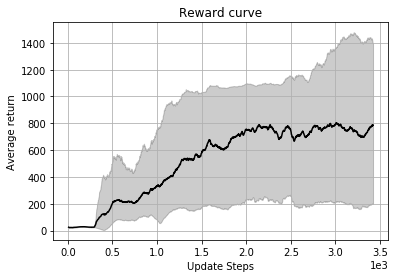

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
# %%
fig, ax = plt.subplots(1,1)

#log_dir = script_path + './walker_log'
df_list = []
model_list = []
min_length = float('inf')

#trial_path = "/home/sgillen/work/lorenz/run_stable/data/mj15/td30/"
trial_path = "/home/sgillen/work/contact/run_stable/data_pbp/td3/rest_35_long"


for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        config = json.load(open(entry.path))
        continue
    
    df = load_results(entry.path)


    if len(df['r']) < min_length:
        min_length = len(df['r'])

    #plt.plot(df['r'])
    plt.figure()
    df_list.append(df)
    model_list.append(ALGO.load(entry.path + "/model.zip"))

min_length = int(min_length)
rewards = np.zeros((min_length, len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

smooth_bounded_curve(rewards[:min_length], ax=ax)
 
ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#fig.savefig(script_path + '../figs/reward.png')
plt.figure() 

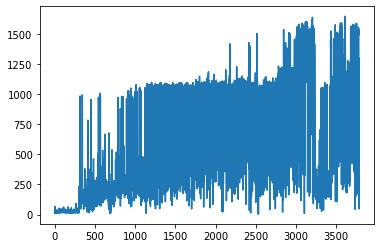

/home/sgillen/miniconda3/envs/stable/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__
reward sum: 1242.7958984375


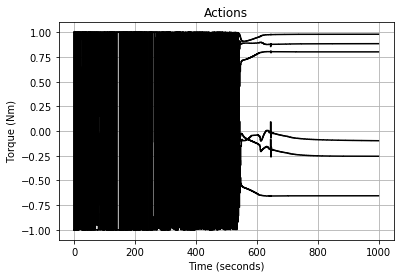

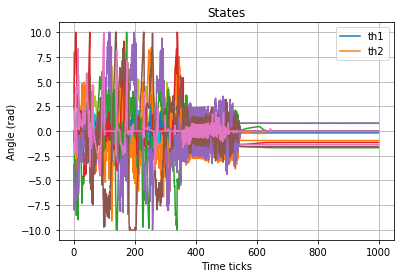

In [3]:
trial_num = 0

model = model_list[trial_num]
df = df_list[trial_num]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=True, video=False)

print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('Angle (rad)')
plt.legend(['th1', 'th2'])
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()

In [4]:
folder = "/home/sgillen/work/contact/run_stable/tmp_video"
import matplotlib.cm as cm
import subprocess
import glob

def generate_video(img):
    for i in range(len(img)):
        plt.imshow(img[i], cmap=cm.Greys_r)
        plt.savefig(folder + "/file%02d.png" % i)

    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [31]:
import cv2

#fourcc = cv2.VideoWriter_fourcc(*'X264')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'MJPG')

video_dir = "./tmp_video/"
text = "/".join(trial_path.split("/")[4:]) + "--" + "trial_" + str(trial_num)
video = cv2.VideoWriter(video_dir + "video.mp4", fourcc, 60, (img_list[0].shape[1],img_list[0].shape[0]))
assert(video.isOpened())

for frame in img_list:
    position = (5,230)
    frame = cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, .25, (0, 0, 0, 0), 1)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    video.write(frame)
    
video.release()

In [4]:
obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=False, video=True)

from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(img_list, fps=60)
clip.write_gif("test.gif", fps=60)

WalkerBase::__init__


t:   2%|▏         | 20/1001 [00:00<00:05, 195.43it/s, now=None]

MoviePy - Building file test.gif with imageio.


t:   2%|▏         | 19/1001 [00:00<00:05, 189.06it/s, now=None]

MoviePy - Building file test.gif with imageio.
